In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [87]:
top10_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top10_de_genes_ra_GSE89408)

10

In [88]:
dataset = (
    get_pre_processed_dataset(
        data_loader=ConditionSequencingTissueDataLoader(
            condition=Condition.SSc,
            sequencing_technique=SequencingTechnique.RNA_SEQ,
            tissue=TissueEnum.PERIPHERAL_BLOOD,
            genes=top10_de_genes_ra_GSE89408
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
dataset

Sample,AC068631.2,AC025259.1,AC025423.4,AC017083.2,HSPE1-MOB4,U62317.1,class_label
str,f64,f64,f64,f64,f64,f64,i8
"""GSM3520102""",6.861825,6.009442,7.579397,7.433053,7.41367,4.588679,0
"""GSM3520103""",6.990878,5.807543,7.45721,6.766297,6.615766,4.628111,0
"""GSM3520104""",5.263421,0.0,6.887851,7.204802,6.142101,3.751688,0
"""GSM3520105""",6.811995,0.0,6.773178,7.331644,6.862178,4.57705,0
"""GSM3520106""",5.391693,5.043774,7.086828,6.832256,6.699806,4.99938,0
…,…,…,…,…,…,…,…
"""GSM3520170""",5.160307,6.694105,5.707972,6.706163,5.888119,5.0511,1
"""GSM3520171""",5.406383,5.311457,6.536449,6.695277,5.551908,6.242616,1
"""GSM3520172""",5.214963,5.288918,6.5664,6.760858,6.610332,5.393195,1


In [89]:
dataset.select(pl.col("class_label").value_counts()) 

class_label
struct[2]
"{0,18}"
"{1,55}"


In [90]:
x_df = (
        dataset.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,AC068631.2,AC025259.1,AC025423.4,AC017083.2,HSPE1-MOB4,U62317.1
0,6.861825,6.009442,7.579397,7.433053,7.413670,4.588679
1,6.990878,5.807543,7.457210,6.766297,6.615766,4.628111
2,5.263421,0.000000,6.887851,7.204802,6.142101,3.751688
3,6.811995,0.000000,6.773178,7.331644,6.862178,4.577050
4,5.391693,5.043774,7.086828,6.832256,6.699806,4.999380
...,...,...,...,...,...,...
68,5.160307,6.694105,5.707972,6.706163,5.888119,5.051100
69,5.406383,5.311457,6.536449,6.695277,5.551908,6.242616
70,5.214963,5.288918,6.566400,6.760858,6.610332,5.393195
71,6.615012,4.983589,7.278092,6.333762,6.296758,5.239003


In [91]:
y_df = dataset.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
68,1
69,1
70,1
71,1


In [92]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [93]:
x_train

,AC068631.2,AC025259.1,AC025423.4,AC017083.2,HSPE1-MOB4,U62317.1
43,5.268729,5.635636,7.439088,6.249895,6.854063,5.020697
63,4.727236,5.451314,6.244468,6.742284,6.514742,5.247847
52,5.570663,4.920985,6.620018,6.705874,6.279522,4.879359
67,5.659072,4.776950,6.426713,7.216891,6.250217,5.189690
64,5.488947,5.956322,7.456833,7.480160,7.052333,5.840933
1,6.990878,5.807543,7.457210,6.766297,6.615766,4.628111
5,7.108448,4.931027,7.526378,7.816711,6.704200,4.716495
18,7.415022,6.023903,7.530620,7.222151,6.783391,5.733478
51,5.892744,4.998981,7.308723,6.802627,6.944149,5.555312
16,6.253166,5.590161,7.371599,6.900082,6.431512,4.863107


In [94]:
y_train

,y
43,0
63,1
52,1
67,1
64,1
1,0
5,0
18,1
51,1
16,1


In [95]:
y_train.value_counts()

y
1    38
0    13
Name: count, dtype: int64

In [96]:
x_test

,AC068631.2,AC025259.1,AC025423.4,AC017083.2,HSPE1-MOB4,U62317.1
69,5.406383,5.311457,6.536449,6.695277,5.551908,6.242616
7,6.647386,5.317574,7.251958,7.318202,6.556216,4.118551
44,5.731205,5.870676,6.976252,7.424087,6.934466,4.895124
61,5.973242,5.705920,6.783428,6.692034,5.973242,6.290570
32,7.202156,6.688533,7.461658,7.969008,6.421797,5.208789
20,6.894286,5.370910,7.579071,7.496581,6.194982,4.170140
23,5.992374,5.629735,7.195140,7.328123,6.490899,4.658582
35,4.187824,5.896369,7.378141,7.446218,7.209299,5.839642
24,6.605580,6.383012,7.355599,7.336607,4.618238,3.899351
33,5.764175,5.435508,7.702904,6.790736,6.075411,4.532614


In [97]:
y_test

,y
69,1
7,0
44,0
61,1
32,1
20,1
23,1
35,1
24,1
33,1


In [98]:
y_test.value_counts()

y
1    17
0     5
Name: count, dtype: int64

# Logistic Regression 

Default Parameters of Base Model: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Scores (cv=4): 0.6923076923076923,0.8461538461538461,0.7692307692307693,0.9166666666666666
Cross Validation gives 0.81 accuracy with a standard deviation of 0.08

Metrics on the Test Set:

 

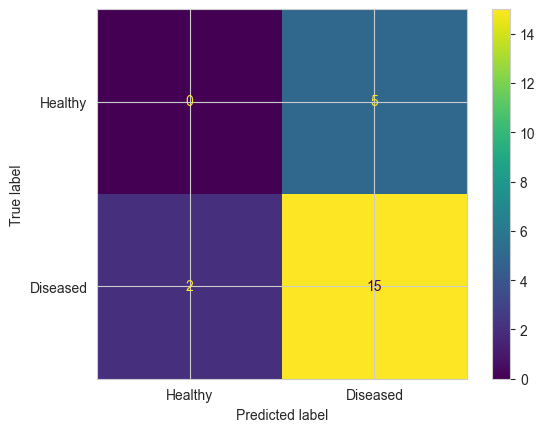

In [99]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)

In [100]:
logistic_model.intercept_

array([0.0204281])

In [101]:
logistic_model.coef_

array([[ 0.05276633,  0.42256984, -0.99898753,  0.4150639 , -0.50633796,
         1.19797817]])

In [102]:
logistic_model.predict_proba(x_test)

array([[0.03027536, 0.96972464],
       [0.49364761, 0.50635239],
       [0.21943469, 0.78056531],
       [0.03699372, 0.96300628],
       [0.11216734, 0.88783266],
       [0.48676708, 0.51323292],
       [0.29657617, 0.70342383],
       [0.14204114, 0.85795886],
       [0.25045143, 0.74954857],
       [0.47534237, 0.52465763],
       [0.46031819, 0.53968181],
       [0.09793017, 0.90206983],
       [0.28465052, 0.71534948],
       [0.51897868, 0.48102132],
       [0.13114824, 0.86885176],
       [0.34477513, 0.65522487],
       [0.25493474, 0.74506526],
       [0.39159589, 0.60840411],
       [0.09143203, 0.90856797],
       [0.67405323, 0.32594677],
       [0.34977495, 0.65022505],
       [0.09590152, 0.90409848]])

# Visualization

(0.6, 1.0)

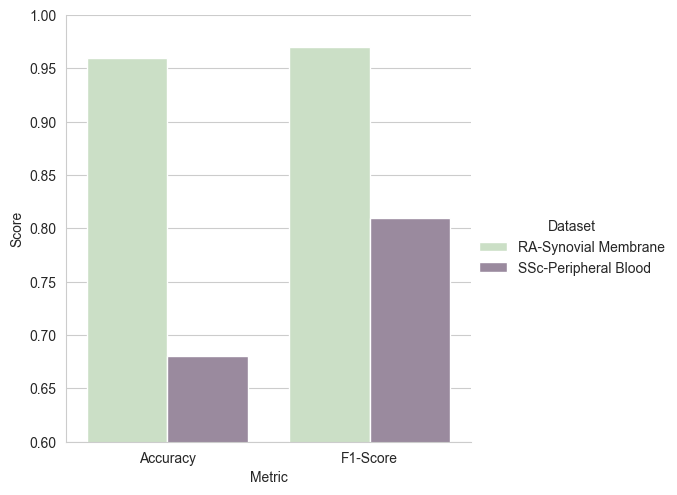

In [110]:
plot = sns.catplot(
    data=pd.DataFrame(
        columns=["Metric", "Dataset", "Score"],
        data = [
            ["Accuracy", "RA-Synovial Membrane", 0.96],
            ["Accuracy", "SSc-Peripheral Blood", 0.68],

            ["F1-Score", "RA-Synovial Membrane", 0.97],
            ["F1-Score", "SSc-Peripheral Blood", 0.81],
        ]
    ),
    x="Metric",
    y="Score",
    hue="Dataset",
    kind="bar",
    palette=sns.color_palette(["#c9e3c2","#9c87a1"])
)
plt.ylim(0.6, 1.0)

(0.6, 1.0)

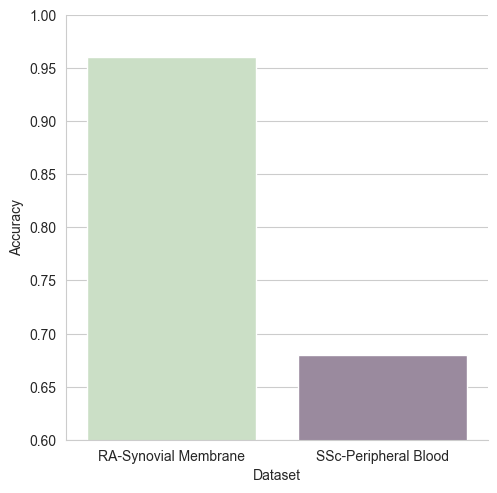

In [118]:
plot = sns.catplot(
    data=pd.DataFrame(
        columns=["Dataset", "Accuracy"],
        data = [
            ["RA-Synovial Membrane", 0.96],
            ["SSc-Peripheral Blood", 0.68],
        ]
    ),
    x="Dataset",
    y="Accuracy",
    hue="Dataset",
    kind="bar",
    palette=sns.color_palette(["#c9e3c2","#9c87a1"])
)
plt.ylim(0.6, 1.0)